# Momentum Contrast (MoCo) implementation

In [1]:
import scipy
import shutil
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import preprocessing
from tqdm import tqdm
import torch.optim as optim

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import TensorDataset, Subset, ConcatDataset

import torch.nn as nn
import torch.nn.functional as F

import time
import os
import pickle
from collections import Counter

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


**Create MoCo model**

In [4]:
class MoCoModel(nn.Module):

  def __init__(self, base_encoder, dim=128, K=4096, m=0.999, T=0.07, batch_size=128, mlp=False):

    super(MoCoModel, self).__init__()

    self.K = K
    self.m = m
    self.T = T
    self.batch_size = batch_size

    # create the encoders
    self.encoder_q = base_encoder(num_classes=dim)
    self.encoder_k = base_encoder(num_classes=dim)

    if mlp:
      dim_mlp = self.encoder_q.fc.weight.shape[1]
      self.encoder_q.fc = nn.Sequential(
          nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_q.fc
      )
      self.encoder_k.fc = nn.Sequential(
          nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_k.fc
      )


    for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):

      param_k.data.copy_(param_q.data)
      param_k.requires_grad = False # no gradient update

    # create the queue
    with torch.no_grad():
      self.queue = torch.randn(batch_size,moco_K).cuda()
      self.queue = nn.functional.normalize(self.queue, dim=0)

  @torch.no_grad()
  def _momentum_update_key_encoder(self):

    for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
      param_k.data = param_k.data * self.m + param_q.data * (1.0 - self.m)

  @torch.no_grad()
  def _dequeue(self):
      return self.queue[:,:(self.K - self.batch_size)]

  @torch.no_grad()
  def _enqueue(self,k):
      return torch.cat([k, self.queue],dim=1)

  def forward(self, im_q, im_k):
    """
    Input:
        im_q: a batch of query images
        im_k: a batch of key images
    Output:
        logits, targets
    """

    # compute query features
    q = self.encoder_q(im_q)  # queries: NxC
    q = nn.functional.normalize(q, dim=1)

    # compute key features
    with torch.no_grad():
      self._momentum_update_key_encoder()

      k = self.encoder_k(im_k)
      k = nn.functional.normalize(k, dim=1)

    # compute logits
    # positive logits: Nx1
    l_pos = torch.einsum("nc,nc->n", [q, k]).unsqueeze(-1)
    # negative logits: NxK
    l_neg = torch.einsum("nc,ck->nk", [q, self.queue.clone().detach()])

    # logits: Nx(1+K)
    logits = torch.cat([l_pos, l_neg], dim=1)

    # apply temperature
    logits /= self.T

    # labels: positive key indicators
    labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

    # dequeue and enqueue
    self.queue = self._dequeue()
    self.queue = self._enqueue(k)

    return logits, labels

In [5]:
class TwoCropsTransform:
  """Take two random crops of one image as the query and key."""

  def __init__(self, base_transform):
    self.base_transform = base_transform

  def __call__(self, x):
    q = self.base_transform(x)
    k = self.base_transform(x)
    return [q, k]

In [6]:
def saveModel(epoch, model,optimizer,loss,path):
      torch.save({
              'epoch': epoch,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'loss': loss
              }, path)

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

**Data loader**

In [7]:
# Augmentation params
augmentation = [
            transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(0.1306, 0.3081),
        ]

transformer = TwoCropsTransform(transforms.Compose(augmentation))

trainset = datasets.MNIST(root = './data', train = True, download = True, transform = transformer) # Train set
# testset = datasets.MNIST(root = './data', train = False, download = True, transform = transformer) # Test set

100%|██████████| 9912422/9912422 [00:00<00:00, 104221980.23it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34423328.74it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 75682768.62it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5654653.83it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
# select 100 subset data
subset_data = []
for i in range(10):
  label_indices = torch.where(trainset.targets == i)[0]
  random.seed(42)
  subset_indices = random.sample(label_indices.tolist(), 10)
  subset_data.append(Subset(trainset, subset_indices))
subset_data = ConcatDataset(subset_data)

In [9]:
label_data = [subset_data[i][1] for i in range(len(subset_data))]
print(Counter(label_data))

Counter({0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10})


In [10]:
sub_ind = torch.randperm(len(subset_data))[:100]
sub_ind

tensor([56, 53, 49, 50, 28, 18, 27,  1, 74, 34, 41, 12, 83,  8, 95, 90, 84, 92,
        42, 11,  3, 37,  6, 59, 79, 30, 17, 81, 43, 23, 38, 10,  4, 97, 16, 60,
        22, 70, 98, 32,  2, 44, 48, 29, 87, 40, 47,  7, 45, 61, 21, 93, 82, 66,
        65, 54, 76, 39, 99,  5, 62, 88, 15, 33, 71,  0, 91, 69, 58, 13, 36, 26,
        35, 85, 68, 14, 57, 51, 96, 20, 89, 86, 19, 24, 80, 67, 73, 72, 78, 31,
        55, 75, 52, 94, 63, 46, 77, 25, 64,  9])

In [11]:
# check sub indices order and we can see that the order is from 0 to 99
np.sort(sub_ind)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [12]:
ind = torch.randperm(len(trainset))[:60000]
ind = torch.tensor(np.setdiff1d(ind, sub_ind))
ind

tensor([  100,   101,   102,  ..., 59997, 59998, 59999])

In [13]:
# select 59900 data points for training with moco model
trainset_moco = torch.utils.data.Subset(trainset, ind)

# select 100 data points from linear protocol
trainset_linear = torch.utils.data.Subset(trainset, sub_ind)
print("Train set for moco: ", len(trainset_moco))
print("Train set for linear: ", len(trainset_linear))

Train set for moco:  59900
Train set for linear:  100


In [14]:
epochs = 15
batch_size = 128
lr = 0.03

# MoCo params
base_encoder = "resnet50"
moco_dim=128
moco_K=4096
moco_m=0.999
moco_T=0.07

In [15]:
# Create MoCo model
model = MoCoModel(models.__dict__[base_encoder]).cuda(device)

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda(device)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr,
    momentum=0.9,
    weight_decay=1e-4,
)

print(model)

MoCoModel(
  (encoder_q): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [16]:
train_loader = torch.utils.data.DataLoader(
        trainset_moco.dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        drop_last=True,
    )

In [17]:
def training(model, epochs, train_loader, optimizer, criterion, device=None):
  train_losses = []
  train_acc = []

  for e in tqdm(range(epochs)):
      epoch_acc1, epoch_loss = 0.0, 0.0
      running_loss, running_acc1 = 0.0, 0.0

      #switch to training mode
      model.train()

      for i,(images, _) in enumerate(train_loader):

          images[0] = images[0].cuda(device)
          images[1] = images[1].cuda(device)

          # compute output
          output, target = model(im_q=images[0], im_k=images[1])

          loss = criterion(output, target)

          acc1 = accuracy(output, target,  topk=(1,))

          #updating query encoder
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          epoch_acc1 += acc1[0].cpu().numpy()
          epoch_loss += loss.item()

          running_loss += loss.item()
          running_acc1 += acc1[0]

          if ((i+1)%100 == 0):
            print('Epoch :',e+1,'Batch :',(i+1),'Loss :',float(running_loss/100),'Top_acc1 :',float(running_acc1/100))
            running_loss, running_acc1 = 0.0, 0.0

      saveModel(e, model, optimizer, epoch_loss, "moco_model.pth")

      train_losses.append(epoch_loss/len(train_loader))
      train_acc.append(epoch_acc1/len(train_loader))
      print('Epoch :',e+1, 'Loss :',train_losses[e], 'Top acc1 :',train_acc[e])

  return model, train_losses, train_acc

In [18]:
# training moco model
moco_train, moco_losses, moco_acc = training(model, epochs, train_loader, optimizer, criterion, device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 1 Batch : 100 Loss : 0.006409628670662641 Top_acc1 : 100.0
Epoch : 1 Batch : 200 Loss : 0.003921055968385189 Top_acc1 : 100.0
Epoch : 1 Batch : 300 Loss : 0.0034610727126710115 Top_acc1 : 100.0
Epoch : 1 Batch : 400 Loss : 0.0032020816556178034 Top_acc1 : 100.0


  7%|▋         | 1/15 [04:44<1:06:23, 284.57s/it]

Epoch : 1 Loss : 0.004076670261267095 Top acc1 : [100.]
Epoch : 2 Batch : 100 Loss : 0.0029709159606136383 Top_acc1 : 100.0
Epoch : 2 Batch : 200 Loss : 0.0028797350032255054 Top_acc1 : 100.0
Epoch : 2 Batch : 300 Loss : 0.0028242552699521183 Top_acc1 : 100.0
Epoch : 2 Batch : 400 Loss : 0.002787359894718975 Top_acc1 : 100.0


 13%|█▎        | 2/15 [09:26<1:01:21, 283.22s/it]

Epoch : 2 Loss : 0.002850049120099403 Top acc1 : [100.]
Epoch : 3 Batch : 100 Loss : 0.0027380577893927694 Top_acc1 : 100.0
Epoch : 3 Batch : 200 Loss : 0.002721021817997098 Top_acc1 : 100.0
Epoch : 3 Batch : 300 Loss : 0.0027088738861493766 Top_acc1 : 100.0
Epoch : 3 Batch : 400 Loss : 0.0026976377423852684 Top_acc1 : 100.0


 20%|██        | 3/15 [14:04<56:10, 280.84s/it]  

Epoch : 3 Loss : 0.0027127624300316484 Top acc1 : [100.]
Epoch : 4 Batch : 100 Loss : 0.00268101507332176 Top_acc1 : 100.0
Epoch : 4 Batch : 200 Loss : 0.00266953346086666 Top_acc1 : 100.0
Epoch : 4 Batch : 300 Loss : 0.002664703836198896 Top_acc1 : 100.0
Epoch : 4 Batch : 400 Loss : 0.0026633495488204064 Top_acc1 : 100.0


 27%|██▋       | 4/15 [18:43<51:19, 279.95s/it]

Epoch : 4 Loss : 0.0026675573690460087 Top acc1 : [100.]
Epoch : 5 Batch : 100 Loss : 0.0026516659185290337 Top_acc1 : 100.0
Epoch : 5 Batch : 200 Loss : 0.0026491490192711354 Top_acc1 : 100.0
Epoch : 5 Batch : 300 Loss : 0.002645266018807888 Top_acc1 : 100.0
Epoch : 5 Batch : 400 Loss : 0.0026408077939413487 Top_acc1 : 100.0


 33%|███▎      | 5/15 [23:22<46:35, 279.54s/it]

Epoch : 5 Loss : 0.002645956590656255 Top acc1 : [100.]
Epoch : 6 Batch : 100 Loss : 0.0026369264721870424 Top_acc1 : 100.0
Epoch : 6 Batch : 200 Loss : 0.002635494016576558 Top_acc1 : 100.0
Epoch : 6 Batch : 300 Loss : 0.0026322199148125945 Top_acc1 : 100.0
Epoch : 6 Batch : 400 Loss : 0.0026314909779466687 Top_acc1 : 100.0


 40%|████      | 6/15 [28:05<42:06, 280.76s/it]

Epoch : 6 Loss : 0.0026334738727006265 Top acc1 : [100.]
Epoch : 7 Batch : 100 Loss : 0.002627207657787949 Top_acc1 : 100.0
Epoch : 7 Batch : 200 Loss : 0.0026250714994966984 Top_acc1 : 100.0
Epoch : 7 Batch : 300 Loss : 0.002624631018843502 Top_acc1 : 100.0
Epoch : 7 Batch : 400 Loss : 0.002623163496609777 Top_acc1 : 100.0


 47%|████▋     | 7/15 [32:44<37:22, 280.32s/it]

Epoch : 7 Loss : 0.002624433927444948 Top acc1 : [100.]
Epoch : 8 Batch : 100 Loss : 0.0026216572197154163 Top_acc1 : 100.0
Epoch : 8 Batch : 200 Loss : 0.0026200802787207066 Top_acc1 : 100.0
Epoch : 8 Batch : 300 Loss : 0.0026185581204481423 Top_acc1 : 100.0
Epoch : 8 Batch : 400 Loss : 0.0026171997119672596 Top_acc1 : 100.0


 53%|█████▎    | 8/15 [37:26<32:45, 280.74s/it]

Epoch : 8 Loss : 0.002618879542992506 Top acc1 : [100.]
Epoch : 9 Batch : 100 Loss : 0.0026156618120148777 Top_acc1 : 100.0
Epoch : 9 Batch : 200 Loss : 0.0026151202083565294 Top_acc1 : 100.0
Epoch : 9 Batch : 300 Loss : 0.0026127630844712257 Top_acc1 : 100.0
Epoch : 9 Batch : 400 Loss : 0.0026134522538632157 Top_acc1 : 100.0


 60%|██████    | 9/15 [42:08<28:07, 281.26s/it]

Epoch : 9 Loss : 0.002613945716383079 Top acc1 : [100.]
Epoch : 10 Batch : 100 Loss : 0.0026114410697482527 Top_acc1 : 100.0
Epoch : 10 Batch : 200 Loss : 0.0026100776134990156 Top_acc1 : 100.0
Epoch : 10 Batch : 300 Loss : 0.0026115703769028185 Top_acc1 : 100.0
Epoch : 10 Batch : 400 Loss : 0.0026098571461625397 Top_acc1 : 100.0


 67%|██████▋   | 10/15 [46:51<23:27, 281.55s/it]

Epoch : 10 Loss : 0.0026105033630767884 Top acc1 : [100.]
Epoch : 11 Batch : 100 Loss : 0.0026070857024751604 Top_acc1 : 100.0
Epoch : 11 Batch : 200 Loss : 0.002607253713067621 Top_acc1 : 100.0
Epoch : 11 Batch : 300 Loss : 0.0026078643882647156 Top_acc1 : 100.0
Epoch : 11 Batch : 400 Loss : 0.002606757921166718 Top_acc1 : 100.0


 73%|███████▎  | 11/15 [51:32<18:46, 281.53s/it]

Epoch : 11 Loss : 0.0026071353598585366 Top acc1 : [100.]
Epoch : 12 Batch : 100 Loss : 0.002605981032829732 Top_acc1 : 100.0
Epoch : 12 Batch : 200 Loss : 0.002604940941091627 Top_acc1 : 100.0
Epoch : 12 Batch : 300 Loss : 0.0026041507185436785 Top_acc1 : 100.0
Epoch : 12 Batch : 400 Loss : 0.002603566937614232 Top_acc1 : 100.0


 80%|████████  | 12/15 [56:13<14:03, 281.25s/it]

Epoch : 12 Loss : 0.0026040597829736895 Top acc1 : [100.]
Epoch : 13 Batch : 100 Loss : 0.0026034406502731143 Top_acc1 : 100.0
Epoch : 13 Batch : 200 Loss : 0.0026014595106244086 Top_acc1 : 100.0
Epoch : 13 Batch : 300 Loss : 0.0026022259960882367 Top_acc1 : 100.0
Epoch : 13 Batch : 400 Loss : 0.002602696779649705 Top_acc1 : 100.0


 87%|████████▋ | 13/15 [1:00:55<09:23, 281.56s/it]

Epoch : 13 Loss : 0.002602099313631526 Top acc1 : [100.]
Epoch : 14 Batch : 100 Loss : 0.0025999183650128543 Top_acc1 : 100.0
Epoch : 14 Batch : 200 Loss : 0.0026002681138925254 Top_acc1 : 100.0
Epoch : 14 Batch : 300 Loss : 0.002601454211398959 Top_acc1 : 100.0
Epoch : 14 Batch : 400 Loss : 0.0025993275945074856 Top_acc1 : 100.0


 93%|█████████▎| 14/15 [1:05:37<04:41, 281.66s/it]

Epoch : 14 Loss : 0.002599862554910569 Top acc1 : [100.]
Epoch : 15 Batch : 100 Loss : 0.00260043163318187 Top_acc1 : 100.0
Epoch : 15 Batch : 200 Loss : 0.0025987885077483953 Top_acc1 : 100.0
Epoch : 15 Batch : 300 Loss : 0.0025986300688236952 Top_acc1 : 100.0
Epoch : 15 Batch : 400 Loss : 0.0025973246293142438 Top_acc1 : 100.0


100%|██████████| 15/15 [1:10:16<00:00, 281.10s/it]

Epoch : 15 Loss : 0.0025986555782664153 Top acc1 : [100.]


In [19]:
def plot_accuracy_loss(model_name, loss_train, acc_train) :
  """plot the accuracy and loss functions (for each epoch)
    early_stop_point = True: visualize the early stopping
  """

  fig = plt.figure(figsize = (16, 8))

  # --- Metrics plot
  def plot_metric(model_name, metric_train, metric_name) :
    """plot metrics of both datasets"""
    plt.plot(range(1, len(metric_train) + 1), metric_train, label='training set', marker='o', linestyle='solid',linewidth=1, markersize=6)
    # find position of lowest validation loss
    plt.title(f"{model_name}-model {metric_name}")
    plt.xlabel('#Epochs')
    plt.ylabel(f'{metric_name}')
    plt.legend(bbox_to_anchor=( 1., 1.))

  # Plot loss functions
  ax = fig.add_subplot(121)
  for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
  plot_metric(model_name, loss_train, "Loss")

  # Plot accuracy function
  ax = fig.add_subplot(122)
  for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
  plot_metric(model_name, acc_train, "Accuracy")

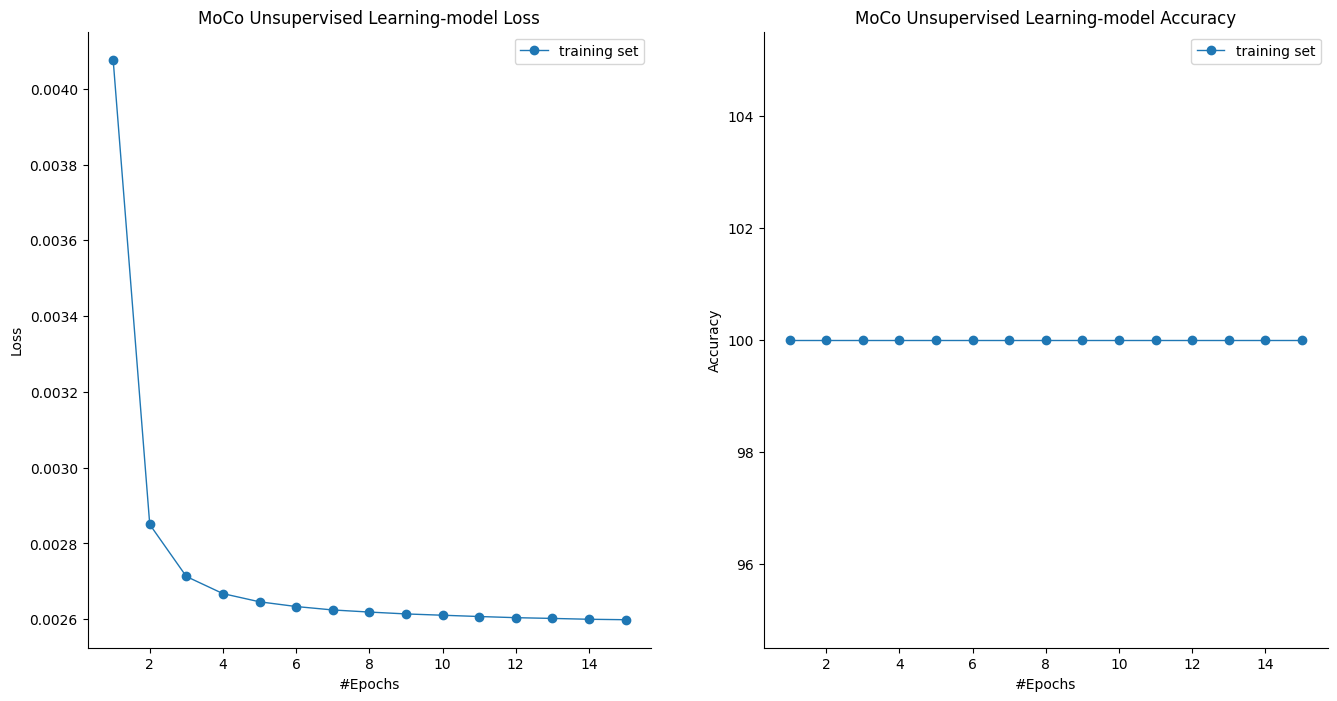

In [20]:
acc_tr = [item for sublist in moco_acc for item in sublist]
plot_accuracy_loss("MoCo Unsupervised Learning", moco_losses, acc_tr)